In [67]:
import numpy as np
import skimage as sk
import skimage.io as skio
import json
import copy
import triangle
import matplotlib.pyplot as plt
import skimage as ski
from PIL import Image
import imageio
import os
from tqdm import tqdm

In [3]:
img_size = (900, 600)

In [4]:
myself = skio.imread("myself.jpg")
  
myself = sk.img_as_float(myself)

In [5]:
jay = skio.imread("Jay.jpg")
  
jay = sk.img_as_float(jay)

In [6]:
with open('myself_Jay.json', 'r') as json_file:
    # Load the JSON data into a Python variable
    correspondence = json.load(json_file)

In [7]:
im1_points = correspondence['im1Points']
im2_points = correspondence['im2Points']

In [8]:
def get_mask(vertices,height,width):
    mask = np.zeros((height, width), dtype=int)
    r = []
    c = []
    for vertice in vertices:
        temp_r = vertice[1]
        temp_c = vertice[0]
        r.append(temp_r)
        c.append(temp_c)
    rr, cc = ski.draw.polygon(r, c)
    mask[rr, cc] = 1 
    return mask

In [10]:
im1_points = im1_points + [[0,0],[599,899],[599,0],[0,899]]

In [9]:
im2_points = im2_points + [[0,0],[599,899],[599,0],[0,899]]

In [14]:
def get_triangular(points):
    points = im2_points

    # Perform Delaunay triangulation
    triangles = triangle.triangulate({'vertices': points})

    triangle_index = triangles['triangles']

    triangles_vertices = triangles['vertices']


    fig, ax = plt.subplots()

    triangle.plot(ax, **triangles)

    ax.set_aspect('equal')

    # Show the plot
    plt.show()
    return  triangle_index

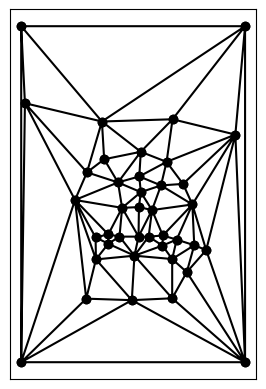

In [15]:
triangle_index = get_triangular(im2_points)

In [16]:
print(im1_points)

[[180, 204], [188, 299], [320, 192], [309, 327], [442, 206], [444, 333], [498, 301], [516, 403], [543, 395], [511, 534], [454, 421], [409, 390], [359, 415], [403, 432], [459, 644], [370, 624], [351, 541], [305, 546], [254, 532], [310, 405], [256, 408], [216, 367], [161, 390], [211, 409], [117, 497], [156, 625], [240, 619], [307, 600], [307, 656], [307, 725], [404, 694], [208, 683], [421, 808], [199, 793], [11, 688], [579, 758], [0, 0], [599, 899], [599, 0], [0, 899]]


In [17]:
def get_mask(vertices, height, width):
    mask = np.zeros((height, width), dtype=int)
    r = []
    c = []
    for vertice in vertices:
        temp_r = vertice[0]
        temp_c = vertice[1]
        r.append(temp_r)
        c.append(temp_c)
    rr, cc = ski.draw.polygon(r, c)
    mask[rr, cc] = 1 
    return mask


In [43]:
def get_transition_mask(im1_points, im2_points, triangle_index, interpolation_coeff ):
    transition_matrix_1 = []
    transition_matrix_2 = []
    mask = []
    mid_points = []
    for i in range(len(im1_points)):
        temp_point_x = int((1-interpolation_coeff)*im1_points[i][0] + interpolation_coeff*im2_points[i][0])
        temp_point_y = int((1-interpolation_coeff)*im1_points[i][1] + interpolation_coeff*im2_points[i][1])
        mid_points.append([temp_point_x,temp_point_y])
    mid_points = np.array(mid_points)
    
    for i in range(len(triangle_index)):
        index = triangle_index[i]
        mid_x = []
        mid_y = []
        x_1 = []
        x_2 = []
        y_1 = []
        y_2 = []
        for j in range(3):
#             mid_x.append((1-interpolation_coeff)*im1_points[index[j]][0] + interpolation_coeff * im2_points[index[j]][0])
#             mid_y.append((1-interpolation_coeff)*im1_points[index[j]][1] + interpolation_coeff * im2_points[index[j]][1])
            
            mid_x.append(mid_points[index[j]][1])
            mid_y.append(mid_points[index[j]][0])
            
            x_1.append(im1_points[index[j]][1])
            y_1.append(im1_points[index[j]][0])
            x_2.append(im2_points[index[j]][1])
            y_2.append(im2_points[index[j]][0])
        mid_point_matrix = np.array([mid_x, mid_y,[1,1,1]])
        point_1_matrix = np.array([x_1, y_1,[1,1,1]])
        point_2_matrix = np.array([x_2, y_2,[1,1,1]])
        temp1 = point_1_matrix @ np.linalg.inv(mid_point_matrix)
        temp2 = point_2_matrix @ np.linalg.inv(mid_point_matrix)
        transition_matrix_1.append(copy.copy(temp1))
        transition_matrix_2.append(copy.copy(temp2))
        temp_mask = get_mask(np.stack((mid_x,mid_y),axis=1),img_size[0],img_size[1])
        mask.append(temp_mask)
    return mid_points, transition_matrix_1, transition_matrix_2, mask

In [56]:
interpolation_coeff = 0.5

In [57]:
mid_points, transition_matrix_1, transition_matrix_2, mask = get_transition_mask(im1_points, im2_points, triangle_index, interpolation_coeff )

In [58]:
img1 = myself
img2 = jay

In [59]:
def check_boundary(x,y, width=img_size[1], height=img_size[0]):
    if x<0 or x >= height:
        return False
    if y<0 or y >= width:
        return False
    return True

In [61]:
def get_mid_Image(img1, img2, im1_points, im2_points,triangle_index, interpolation_coeff,mask):
    mid_image = np.zeros((img1.shape[0], img1.shape[1],3))
    height = img1.shape[0]
    width =  img1.shape[1]
    for i in range(len(triangle_index)):
        index = triangle_index[i]
        for j in range(mid_image.shape[0]):
            for k in range(mid_image.shape[1]):
                if type(i) == float:
                    print('123')
                if type(j) == float:
                    print('123')
                if type(k) == float:
                    print('123')
                if mask[i][j,k] == 1:
                    temp_1 = transition_matrix_1[i] @ np.array([j,k,1])
                    x_1 = int(temp_1[0])
                    y_1 = int(temp_1[1])
                    temp_2 = transition_matrix_2[i] @ np.array([j,k,1])
                    x_2 = int(temp_2[0])
                    y_2 = int(temp_2[1])
                    if check_boundary(x_1, y_1) and check_boundary(x_2,y_2):
                        for l in range(3):
                            mid_image[j,k,l] =  (1-interpolation_coeff)*img1[x_1,y_1,l] + interpolation_coeff*img2[x_2,y_2,l]
    return mid_image

In [62]:
mid_image = get_mid_Image(img1, img2, im1_points, im2_points, triangle_index, interpolation_coeff, mask)

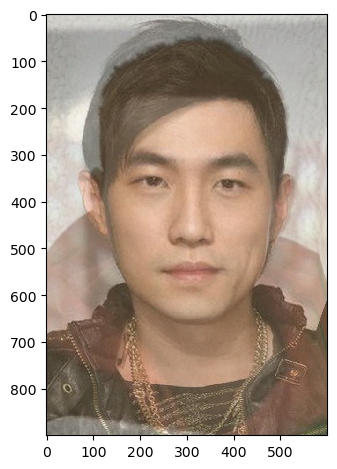

In [63]:
skio.imshow(mid_image)

In [68]:
interpolation_coeffs = np.linspace(0, 1, num=45)
frames = []

for interpolation_coeff in tqdm(interpolation_coeffs):
    mid_points, transition_matrix_1, transition_matrix_2, mask = get_transition_mask(im1_points, im2_points, triangle_index, interpolation_coeff )
    mid_image = get_mid_Image(img1, img2, im1_points, im2_points, triangle_index, interpolation_coeff, mask)
    frames.append(copy.copy(mid_image))


100%|███████████████████████████████████████████| 45/45 [08:50<00:00, 11.80s/it]


In [69]:
output_gif_path = "output.gif"  

imageio.mimsave(output_gif_path, frames, duration=1/30) 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0